In [ ]:
from google.colab import files
files.upload()


In [ ]:
import os
import shutil

# Make a directory for the Kaggle API key
os.makedirs("/root/.kaggle", exist_ok=True)

# Move the kaggle.json file to the directory
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set the permissions
os.chmod("/root/.kaggle/kaggle.json", 600)


In [ ]:
!pip install -q kaggle


In [ ]:
!kaggle datasets download -d muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten

Dataset URL: https://www.kaggle.com/datasets/muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten
License(s): CC0-1.0
100% 4.75G/4.77G [00:41<00:00, 40.3MB/s]
100% 4.77G/4.77G [00:41<00:00, 122MB/s] 


In [ ]:
!unzip -q fruit-and-vegetable-disease-healthy-vs-rotten.zip

In [ ]:
!ls '/content/Fruit And Vegetable Diseases Dataset'

Apple__Healthy	     Grape__Healthy   Pomegranate__Healthy
Apple__Rotten	     Grape__Rotten    Pomegranate__Rotten
Banana__Healthy      Guava__Healthy   Potato__Healthy
Banana__Rotten	     Guava__Rotten    Potato__Rotten
Bellpepper__Healthy  Jujube__Healthy  Strawberry__Healthy
Bellpepper__Rotten   Jujube__Rotten   Strawberry__Rotten
Carrot__Healthy      Mango__Healthy   Tomato__Healthy
Carrot__Rotten	     Mango__Rotten    Tomato__Rotten
Cucumber__Healthy    Orange__Healthy
Cucumber__Rotten     Orange__Rotten


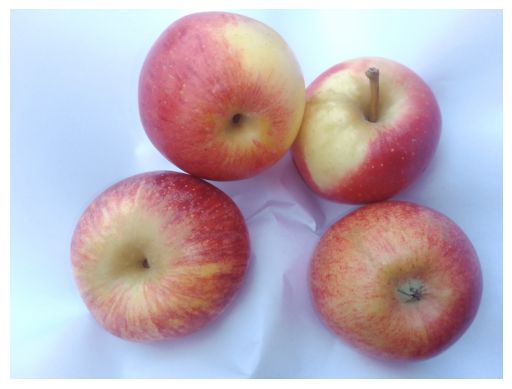

Image format: JPEG
Image size: (4160, 3120)
Image mode: RGB


In [ ]:
#Checking images of the the folder or dataset

from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/Fruit And Vegetable Diseases Dataset/Apple__Healthy/FreshApple (1).jpg' # Replace with a valid path
try:
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"Image format: {img.format}")
    print(f"Image size: {img.size}")
    print(f"Image mode: {img.mode}")
except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
except Exception as e:
    print(f"Error loading image: {e}")

## Data preprocessing

Create data generators for the training, validation, and testing sets using `ImageDataGenerator` and `flow_from_directory`. We will use data augmentation for the training set.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data paths
base_dir = '/content/Fruit And Vegetable Diseases Dataset'

# image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

# Data augmentation and preprocessing for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Data preprocessing for validation and test sets 
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Flow images from directories
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    color_mode='rgb'
)

validation_generator = validation_datagen.flow_from_directory(
    base_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb'
)


print("Data preprocessing complete. Generators created:")
print(f"Training generator: {train_generator.samples} images in {train_generator.num_classes} classes")
print(f"Validation generator: {validation_generator.samples} images in {validation_generator.num_classes} classes")

Found 23431 images belonging to 28 classes.
Found 5846 images belonging to 28 classes.
Data preprocessing complete. Generators created:
Training generator: 23431 images in 28 classes
Validation generator: 5846 images in 28 classes


In [ ]:
class_indices = train_generator.class_indices
print(class_indices)

{'Apple__Healthy': 0, 'Apple__Rotten': 1, 'Banana__Healthy': 2, 'Banana__Rotten': 3, 'Bellpepper__Healthy': 4, 'Bellpepper__Rotten': 5, 'Carrot__Healthy': 6, 'Carrot__Rotten': 7, 'Cucumber__Healthy': 8, 'Cucumber__Rotten': 9, 'Grape__Healthy': 10, 'Grape__Rotten': 11, 'Guava__Healthy': 12, 'Guava__Rotten': 13, 'Jujube__Healthy': 14, 'Jujube__Rotten': 15, 'Mango__Healthy': 16, 'Mango__Rotten': 17, 'Orange__Healthy': 18, 'Orange__Rotten': 19, 'Pomegranate__Healthy': 20, 'Pomegranate__Rotten': 21, 'Potato__Healthy': 22, 'Potato__Rotten': 23, 'Strawberry__Healthy': 24, 'Strawberry__Rotten': 25, 'Tomato__Healthy': 26, 'Tomato__Rotten': 27}


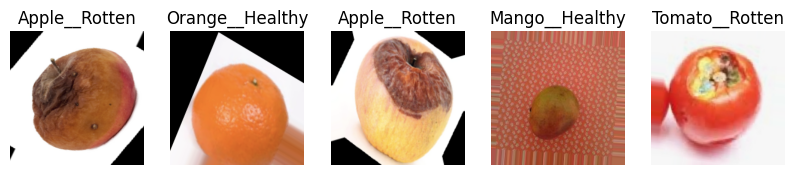

In [ ]:
import matplotlib.pyplot as plt

num_images_to_show = 5

# Get a batch of images and labels from the training generator
images, labels = next(train_generator)

# Get the class names from the generator
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 10))
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(images[i])
    label_index = tf.argmax(labels[i]).numpy()
    plt.title(class_names[label_index])
    plt.axis("off")
plt.show()

## Model building

Load the VGG16 model without the top classification layer, add custom classification layers for your specific problem (identifying rotten fruits and vegetables), and compile the model.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new Sequential model
model = Sequential()

# Add the VGG16 base model
model.add(base_model)

# Add a Flatten layer
model.add(Flatten())

# Add custom classification layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_generator.num_classes, activation='softmax')) # Output layer

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 28)             │         7,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,144,668 (80.66 MB)

 Trainable params: 6,429,980 (24.53 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## **Model Training**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

epochs = 20

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping]
)

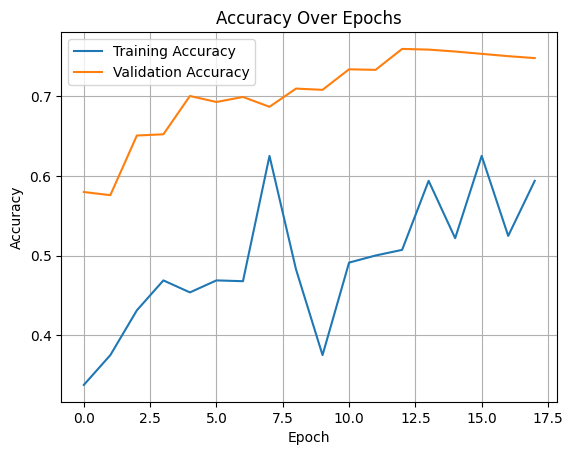

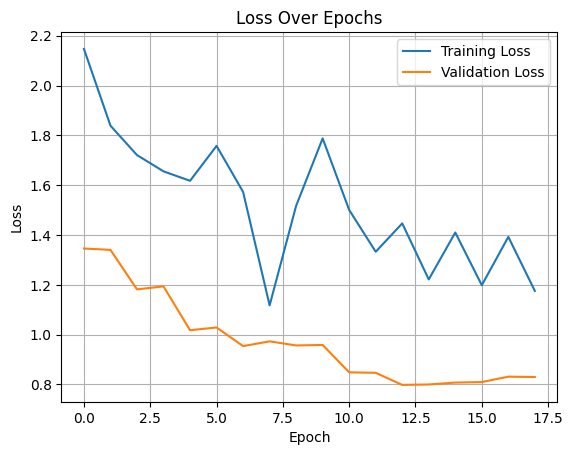

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from google.colab import files
model.save("vgg16_detector.h5")
files.download("vgg16_detector.h5")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>